# Univariate regression to predict the wind speed field

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random

from utils.metrics import MetricsLogger
from utils.data_loaders import get_wake_dataloaders
import utils.utils as uutils
import utils.data_utils as data_utils
import utils.plotting as plotting
from utils.evaluation import test_pytorch_model
#from utils.nerf import NeRF2D

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

In [2]:
# hyperparameters
# in univariate, the batch size is a multiplier for number of cells
# (i.e. the batch_size should be dividible by the number of cells)
BATCH_MULTIPLIER = 8
EPOCHS = 500
LR = 0.01

ACTIVATION_FUNCTION = nn.ReLU() #TODO
N_MAPPING = 32  # Number of Fourier features
HIDDEN_LAYERS_UNITS = [128, 256]

FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"data/{FACTORS_FOLDER}/"
MODEL_NAME = f"univariate_NeRF_{N_MAPPING}fourier-features_layers{'-'.join(str(lu) for lu in HIDDEN_LAYERS_UNITS)}"
BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"
CONSIDER_WS = True
COORDS_AS_INPUT = True # univariate setting
N_COORDINATES = 2  # Number of input coordinates (x and y)
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
    FACTORS_FOLDER = FACTORS_FOLDER.replace("TIstep0.01_CTstep0.01", "reducedTI-CT")
    BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"
print(f"Model name: {MODEL_NAME}")
print(f"Best model path: {BEST_MODEL_PATH}")

MODEL_DESCRIPTION = f"{MODEL_NAME}_{FACTORS_FOLDER}: act. func. {ACTIVATION_FUNCTION.__class__.__name__} " +\
    f"(not last layer), batch multiplier {BATCH_MULTIPLIER}, {EPOCHS} epochs, lr={LR})"
print(f"Model description: {MODEL_DESCRIPTION}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {DEVICE}")

univariate_NeRF_32fourier-features_layers128-256_consider_ws
saved_models/discr_factors_x2_30_y-2_2_step0.125_reducedTI-CT/univariate_NeRF_32fourier-features_layers128-256_consider_ws.pt
DEVICE=device(type='cpu')
MODEL_DESCRIPTION='univariate_NeRF_32fourier-features_layers128-256_consider_ws_discr_factors_x2_30_y-2_2_step0.125_reducedTI-CT: act. func. ReLU (not last layer), batch multiplier 8, 500 epochs, lr=0.01)'


In [3]:
class FourierLayer(nn.Module):
    def __init__(self, n_features: int, n_mapping: int):
        super(FourierLayer, self).__init__()
        self.coefficients = nn.Parameter(torch.randn(n_mapping, n_features))

    def forward(self, x):
        x_proj = 2 * torch.pi * x @ self.coefficients.t()
        out = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        return out

class NeRF2D(nn.Module):
    def __init__(self, n_coordinates: int, n_features: int, output_space: int):
        super(NeRF2D, self).__init__()
        self.fourier_layer = FourierLayer(n_coordinates, N_MAPPING)
        layer_units = [N_MAPPING * 2 + n_features] + HIDDEN_LAYERS_UNITS
        mlp_layers = list()
        for first, second in zip(layer_units, layer_units[1:]):
            mlp_layers += [nn.Linear(first, second), ACTIVATION_FUNCTION]
        mlp_layers.append(nn.Linear(layer_units[-1], output_space)) # last layer not activated
        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self, inputs):
        # Pass coordinates through the Fourier Layer
        coords = inputs[:, -2:]
        input_features = inputs[:, :-2]
        fourier_out = self.fourier_layer(coords)

        # Concatenate Fourier layer output with other input features
        input_features = torch.cat((fourier_out, input_features), dim=-1)

        # Feed-forward through the rest of the neural network
        x = self.mlp(input_features)

        return x

In [4]:
valid_dataloader = None
train_dataloader, valid_dataloader, test_dataloader = get_wake_dataloaders(DATA_FOLDER,
                                                          consider_ws=CONSIDER_WS,
                                                          coords_as_input=COORDS_AS_INPUT,
                                                          train_perc=0.6,
                                                          test_perc=0.2,
                                                          validation_perc=0.2,
                                                          batch_multiplier=BATCH_MULTIPLIER)
len(train_dataloader)

1032

In [5]:
for b in train_dataloader:
    print(b[0].shape, b[1].shape)
    break

input_space = train_dataloader.dataset.inputs.shape[1]
n_features = input_space - N_COORDINATES
output_space = train_dataloader.dataset.outputs.shape[1]
print(f"{input_space=} ({N_COORDINATES} coordinates and {n_features} other input features)\t{output_space=}")

torch.Size([57344, 5]) torch.Size([57344, 1])
input_space=5 (2 coordinates and 3 other input features)	output_space=1


In [6]:
model = NeRF2D(N_COORDINATES, n_features, output_space).to(DEVICE)

optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=LR
)
loss_function = torch.nn.MSELoss()

metrics_logger = MetricsLogger(name=MODEL_NAME)
best_vloss = 1_000_000.
for epoch in range(EPOCHS):
    '''TRAINING'''
    model.train(True)
    epoch_tloss = 0
    for batch in iter(train_dataloader):
        x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)
        optimizer.zero_grad()
        prediction = model(x)
        tloss = loss_function(prediction, y)
        tloss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) TODO
        optimizer.step()

        epoch_tloss += tloss.item() * x.size(0)
        #TODO accuracy or other metric computation????

    avg_tloss = epoch_tloss / len(train_dataloader.sampler)
    metrics_logger.log_metric(epoch, 'Training loss', avg_tloss)

    '''VALIDATION'''
    if valid_dataloader:
        model.train(False)
        epoch_vloss = 0
        for batch in iter(valid_dataloader):
            x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)
            prediction = model(x)
            vloss = loss_function(prediction, y)

            epoch_vloss += vloss.item() * x.size(0)

        avg_vloss = epoch_vloss / len(valid_dataloader.sampler)
        metrics_logger.log_metric(epoch, 'Validation loss', avg_vloss)
        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(model.state_dict(), BEST_MODEL_PATH)


metrics_logger.plot_metrics_by_epoch()
metrics_logger.save_metrics()

Logging univariate_NeRF_32fourier-features_layers128-256_consider_wsMetrics exported in the following csv file: logged_metrics/univariate_NeRF_32fourier-features_layers128-256_consider_ws_07-06-2023_11-46-54.csv

Epoch 0 ->	Training loss=0.0006903428198424853	Validation loss=2.4060935793386306e-05	
Epoch 1 ->	Training loss=1.907939850052847e-05	Validation loss=1.2963584703439582e-05	
Epoch 2 ->	Training loss=1.3217617366260101e-05	Validation loss=1.3259303340915225e-05	
Epoch 3 ->	Training loss=9.434372467667069e-06	Validation loss=5.1786452352396076e-06	

# Testing

In [ ]:
# loading best model
model = NeRF2D(N_COORDINATES, n_features, output_space).to(DEVICE)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()
test_pytorch_model(model, test_dataloader,
                   model_description=f"{MODEL_NAME}_{FACTORS_FOLDER} (act. func. {ACTIVATION_FUNCTION.__class__.__name__})",
                   save_results=True)

Test results for univariate_NeRF_64fourier-features_layers256-256_consider_ws_discr_factors_x2_30_y-2_2_step0.125_reducedTI-CT (act. func. ReLU)
r2_score=0.5914577647547834
explained_variance_score=0.601028323173523
mean_squared_error=0.0005079537513665855
mean_absolute_error=0.007376321591436863
median_absolute_error=0.001692682970315218
mean_absolute_percentage_error=262192250880.0
Prediction time=5.935746889150181e-06s


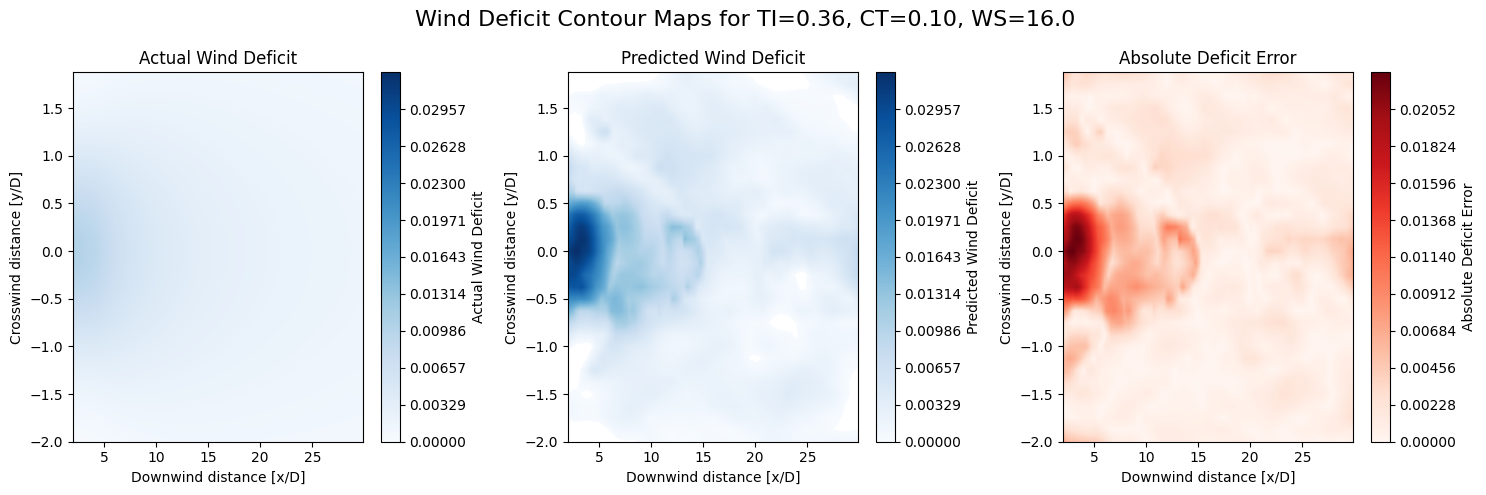

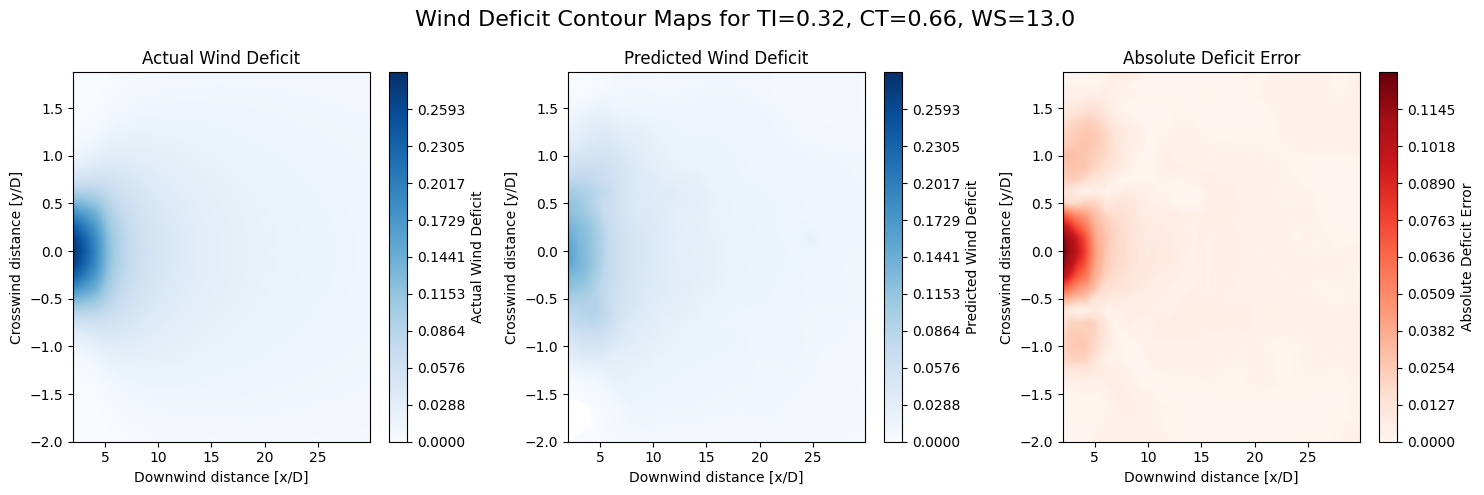

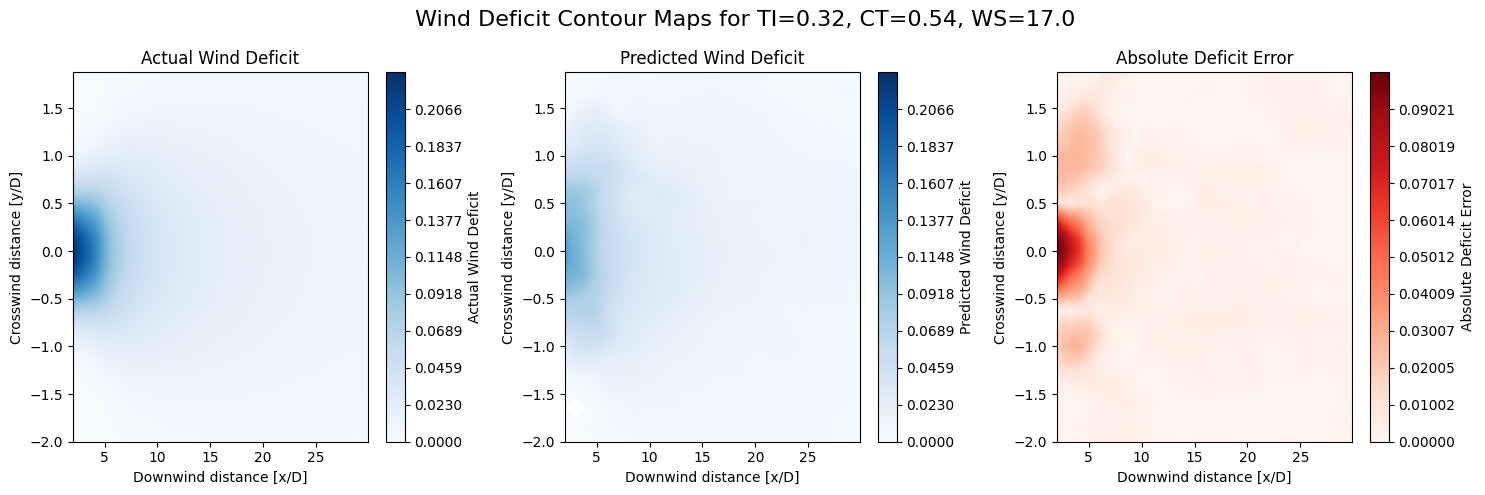

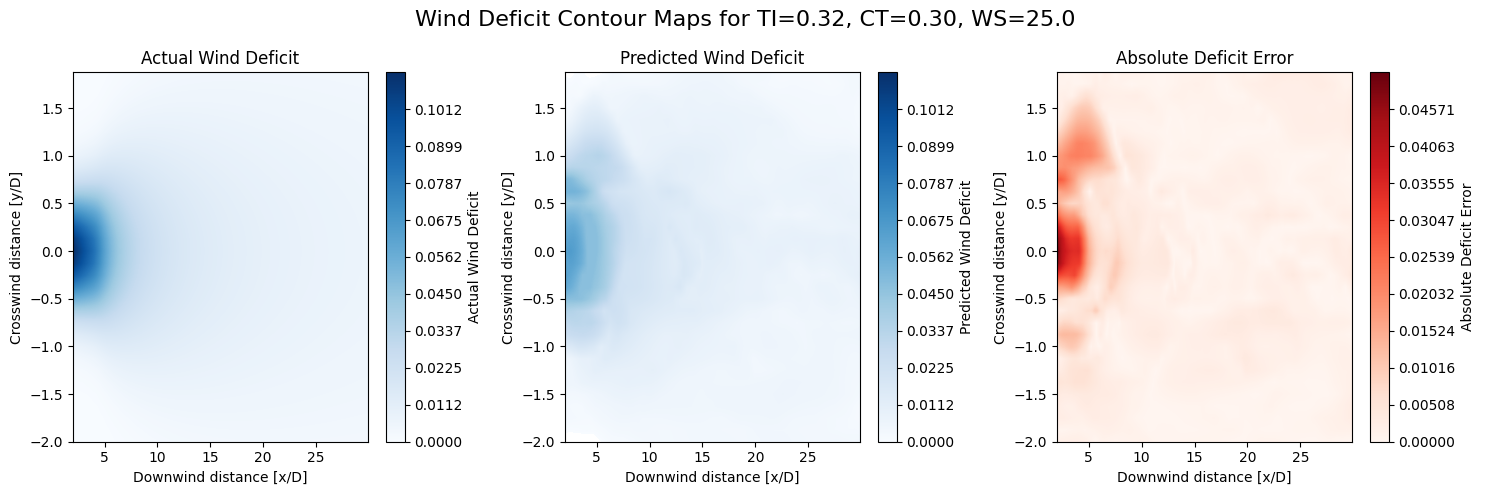

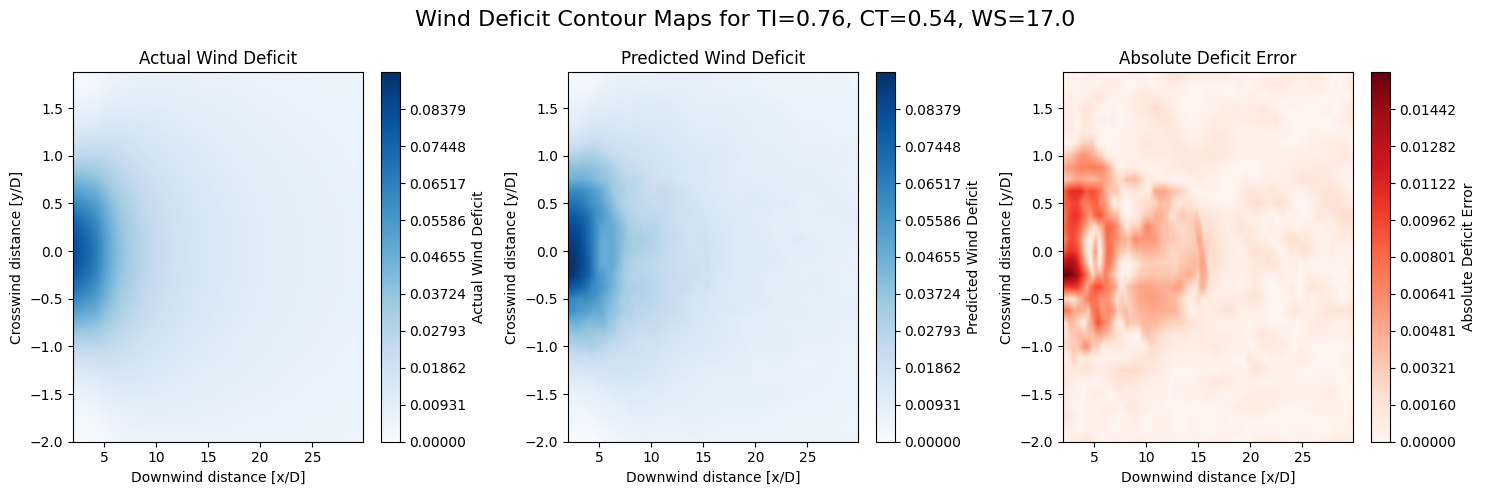

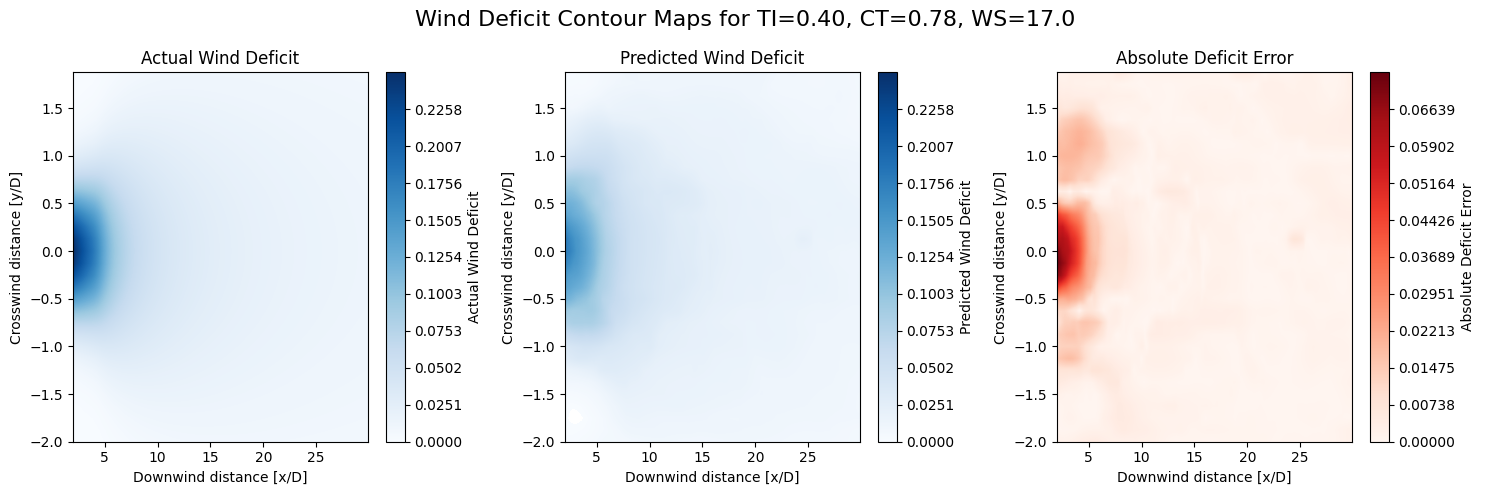

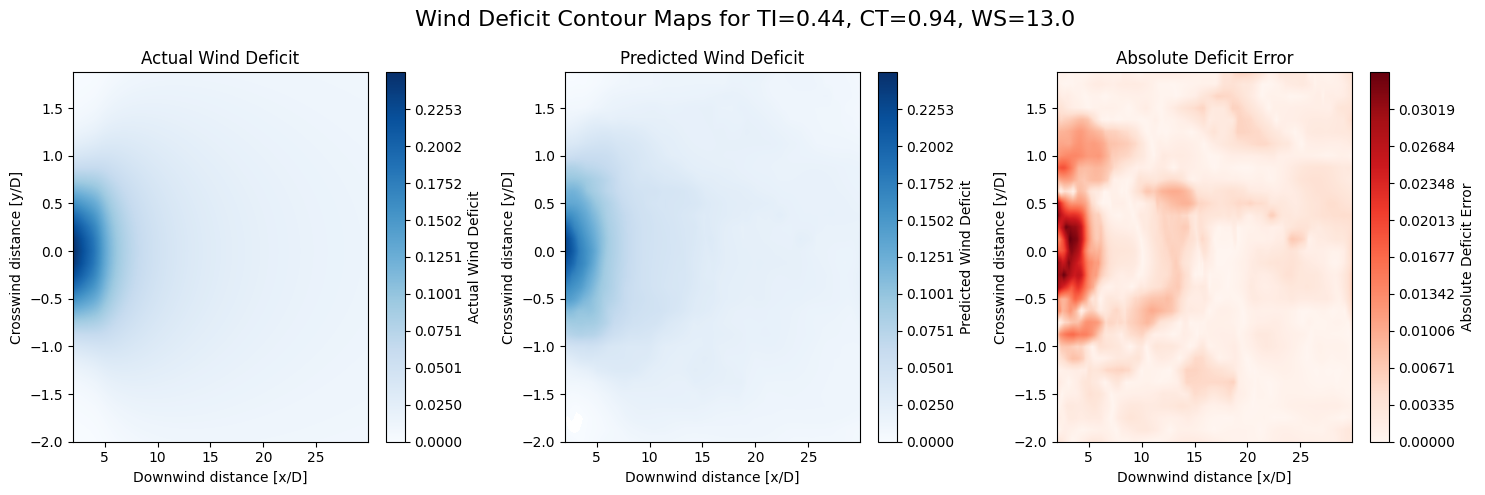

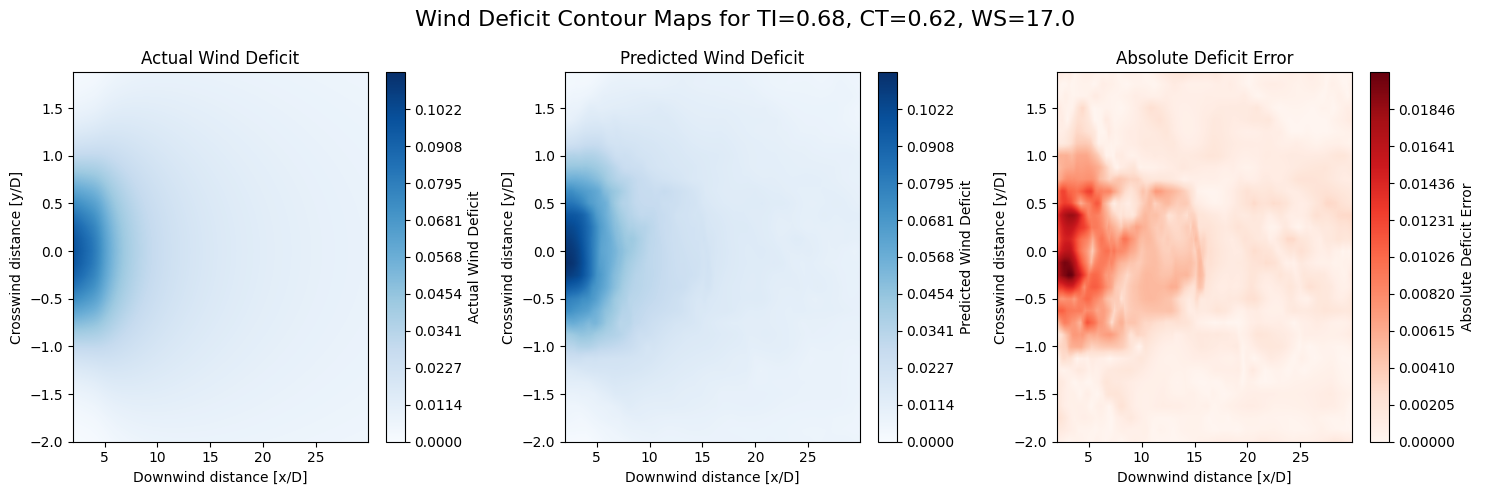

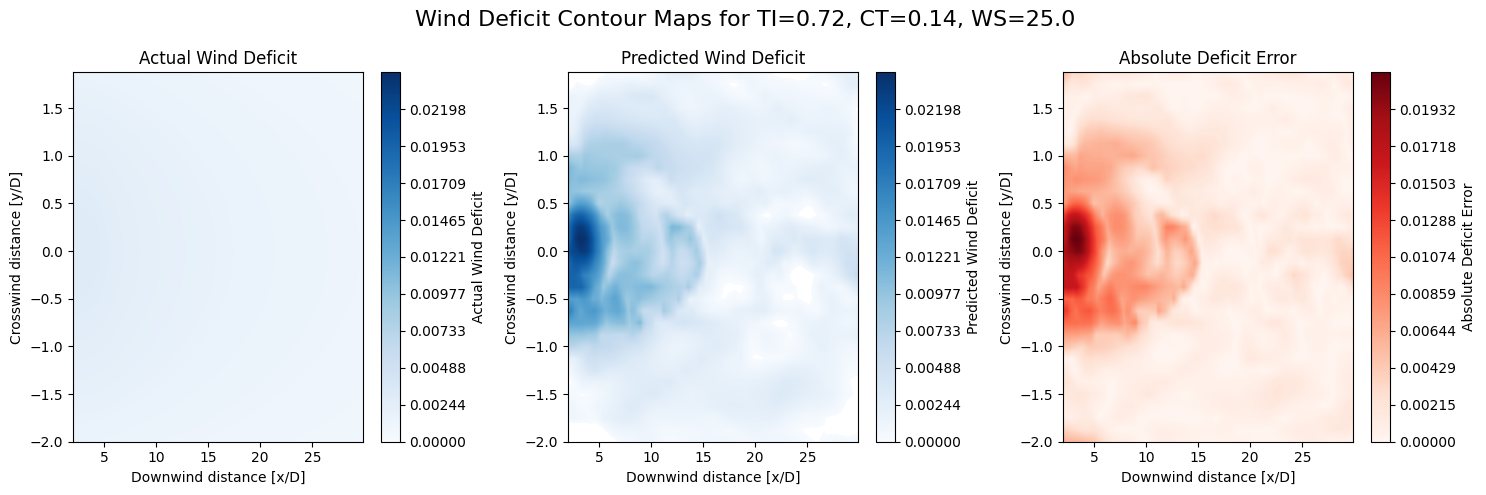

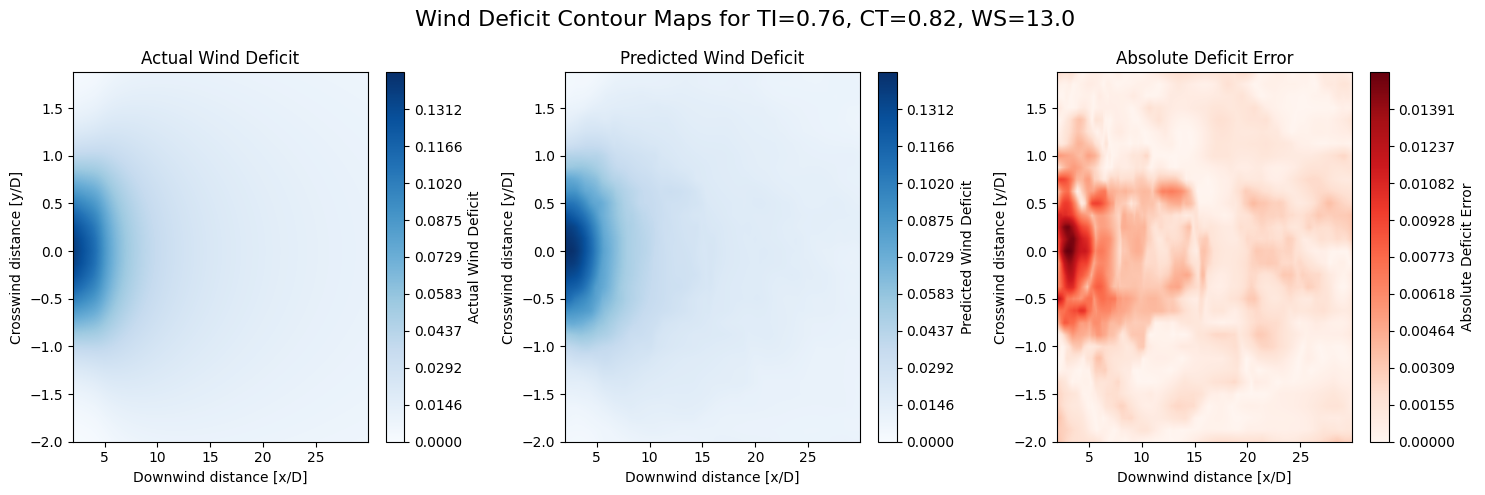

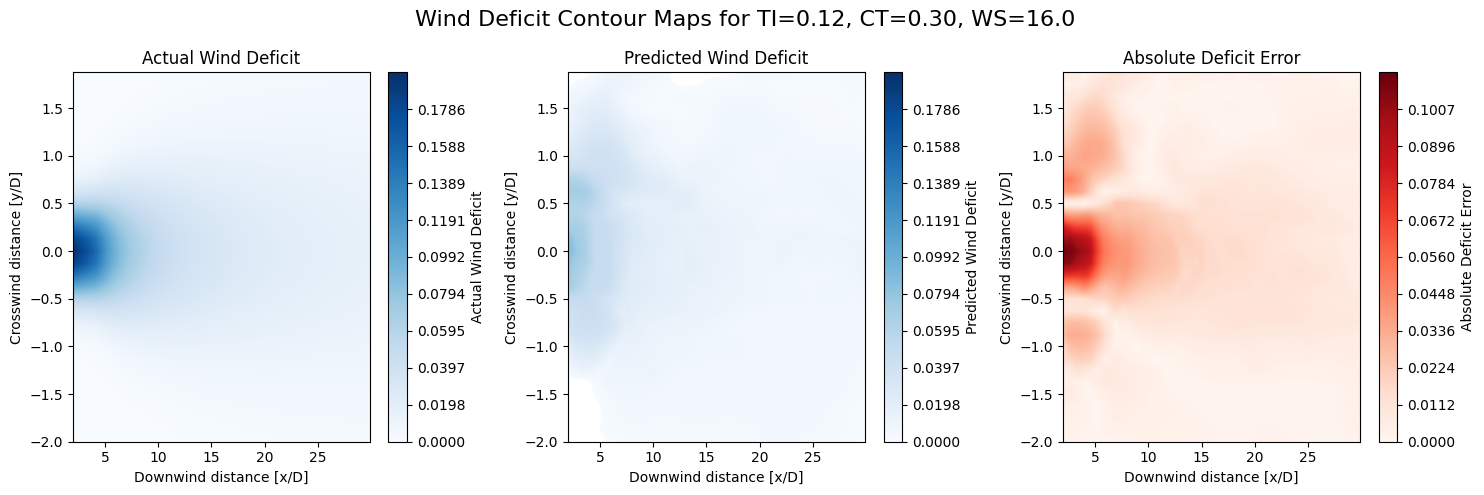

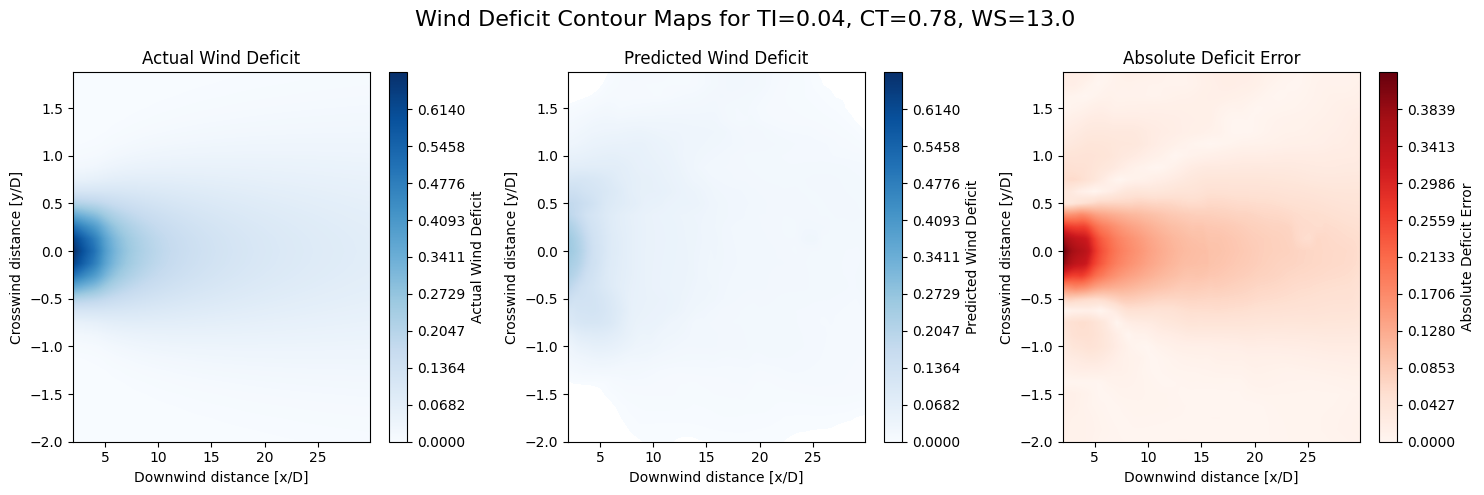

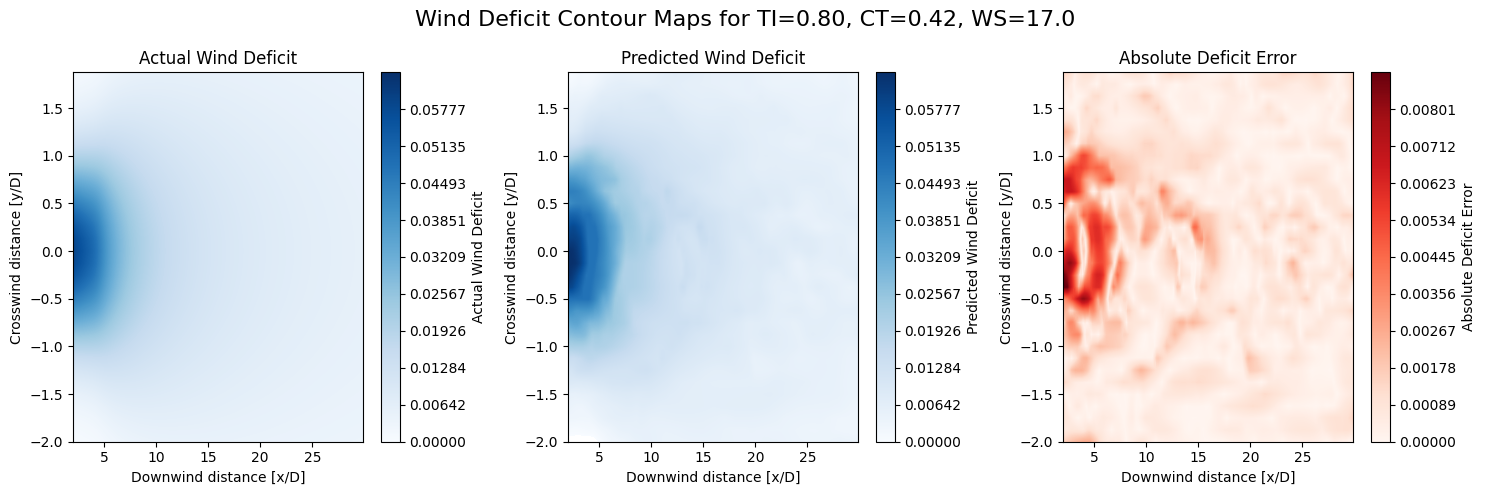

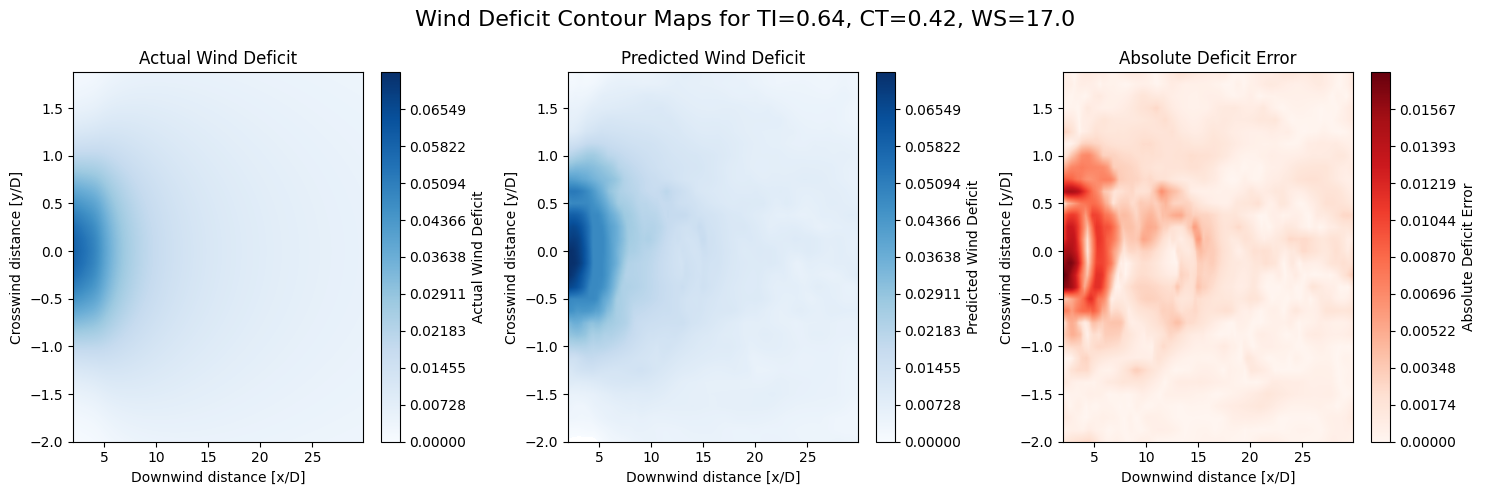

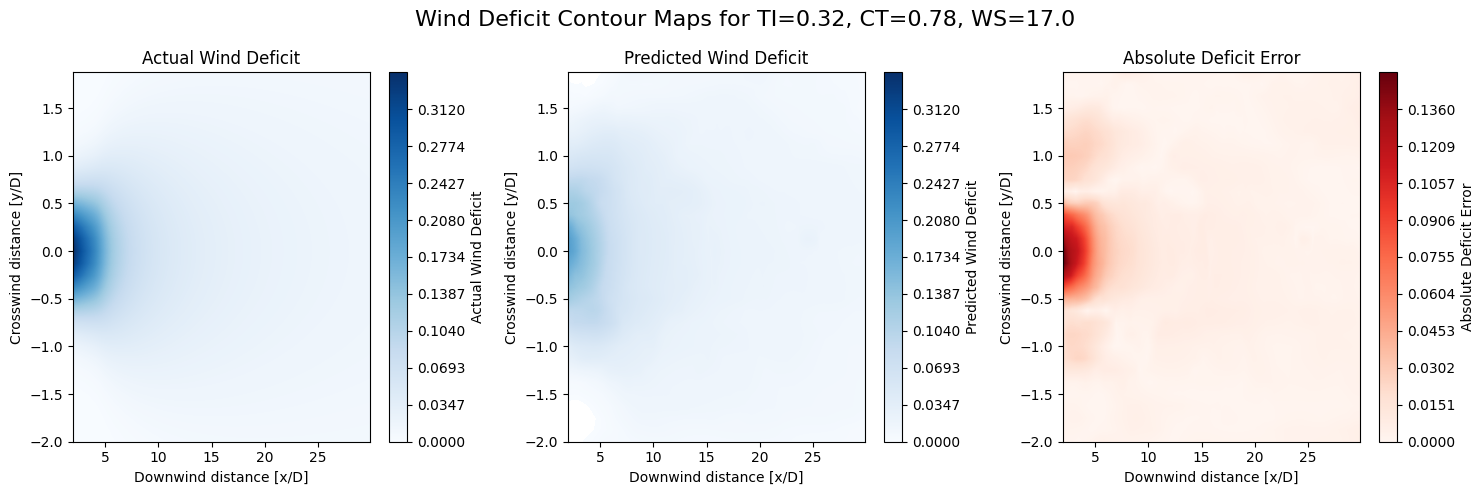

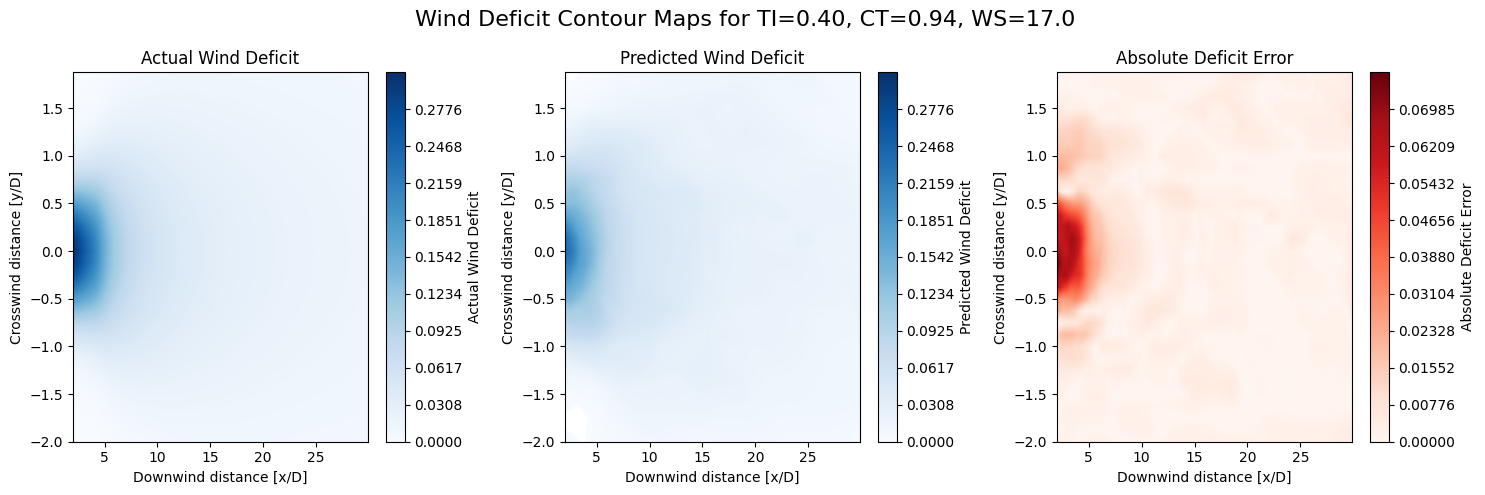

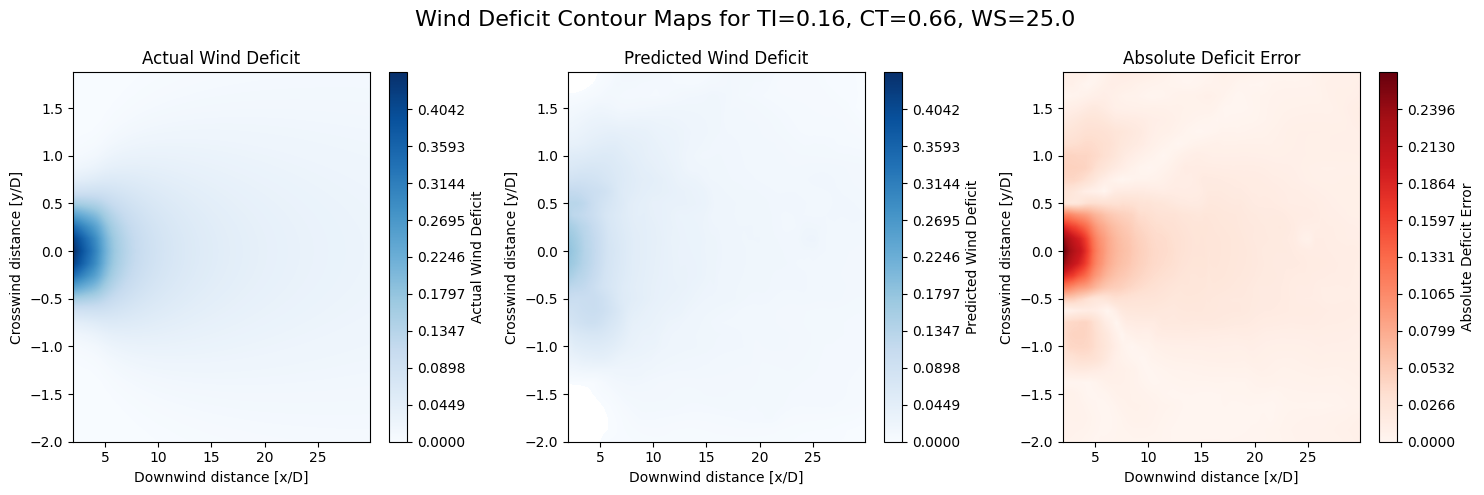

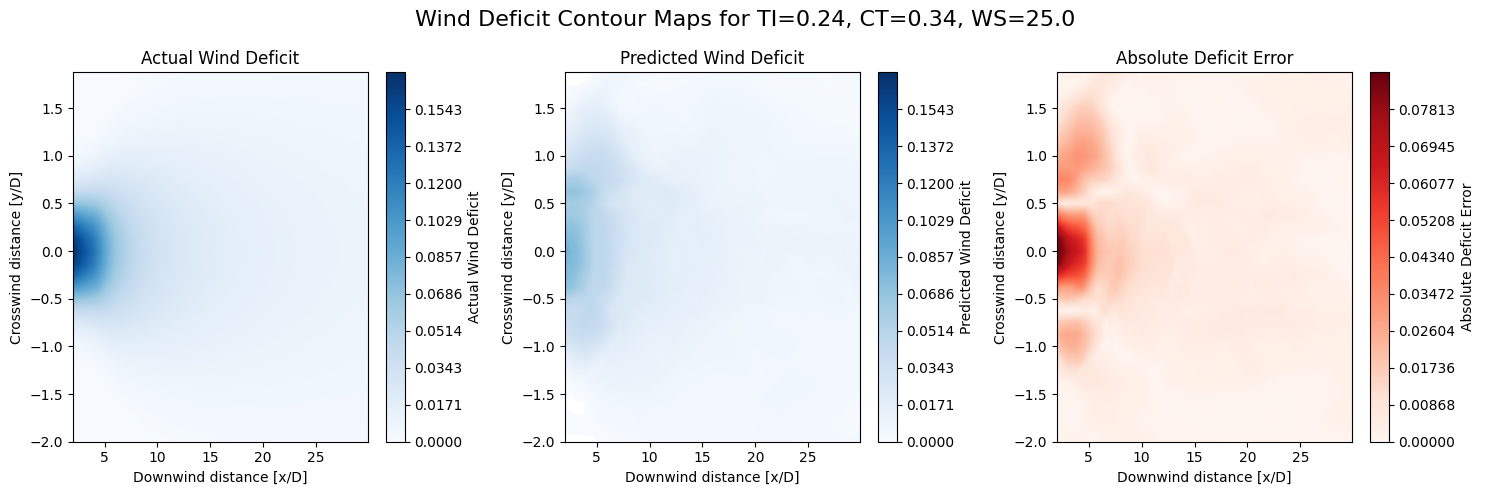

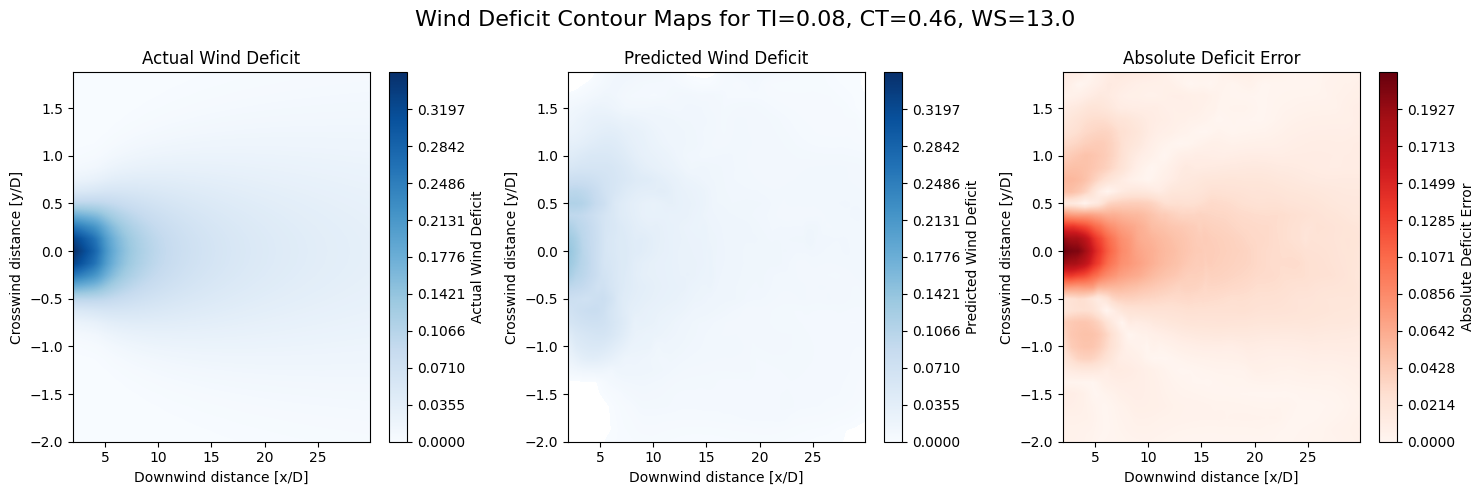

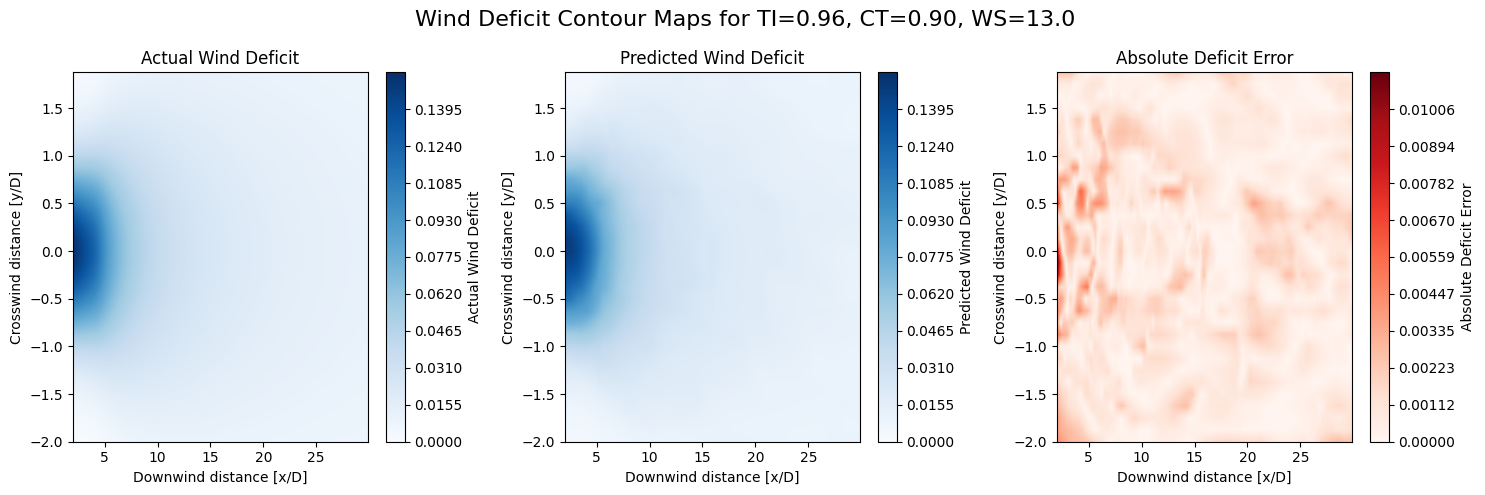

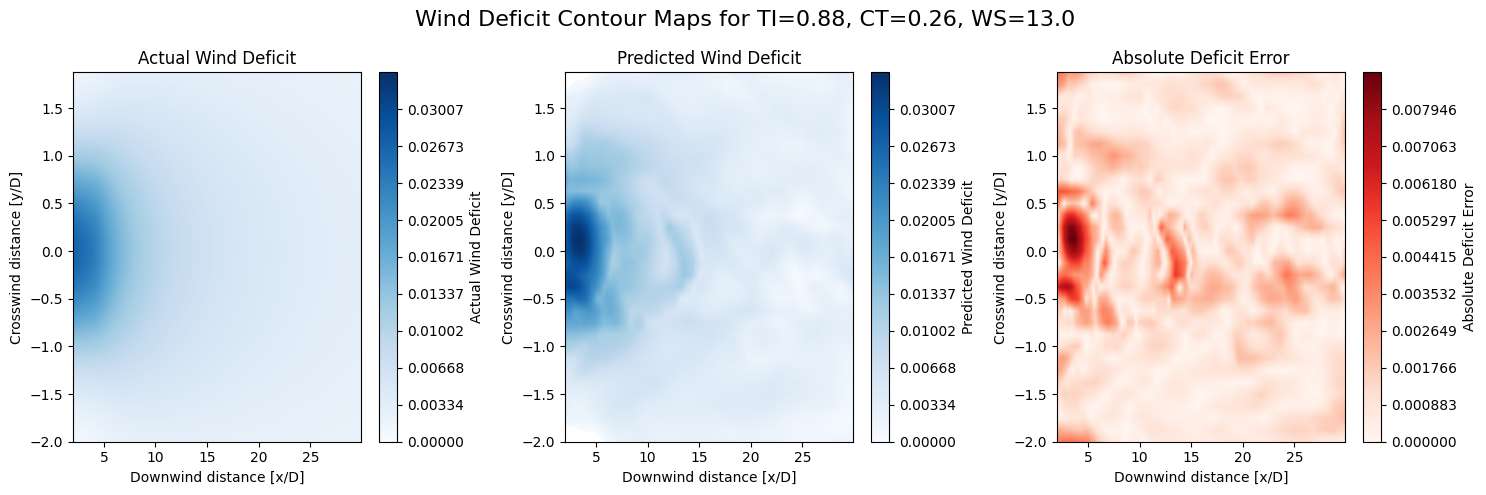

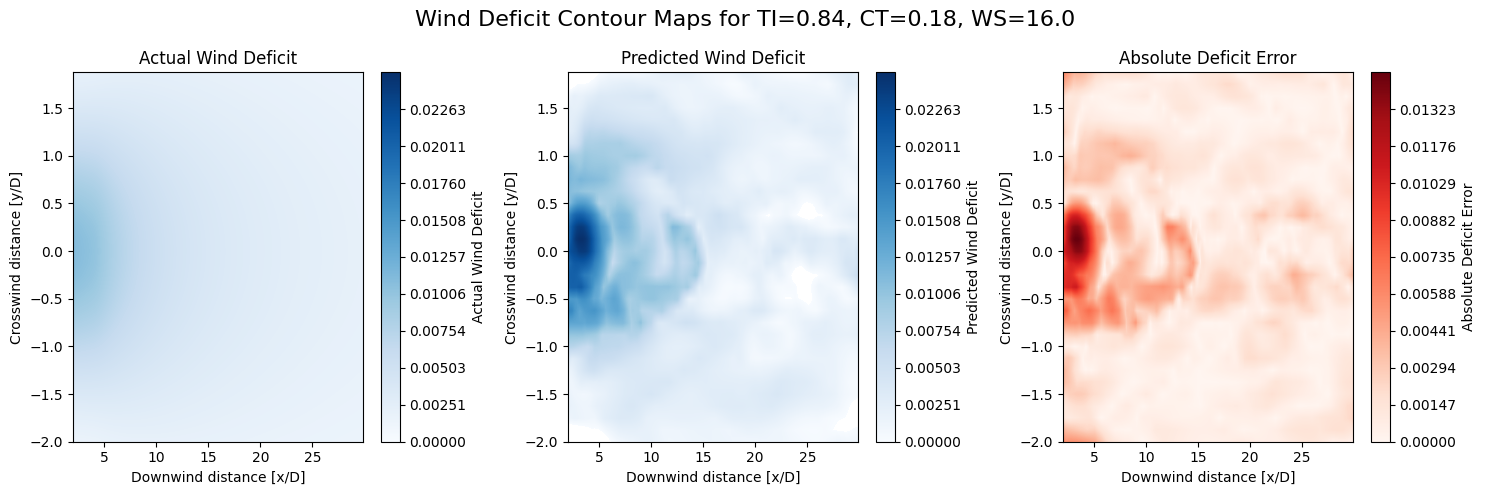

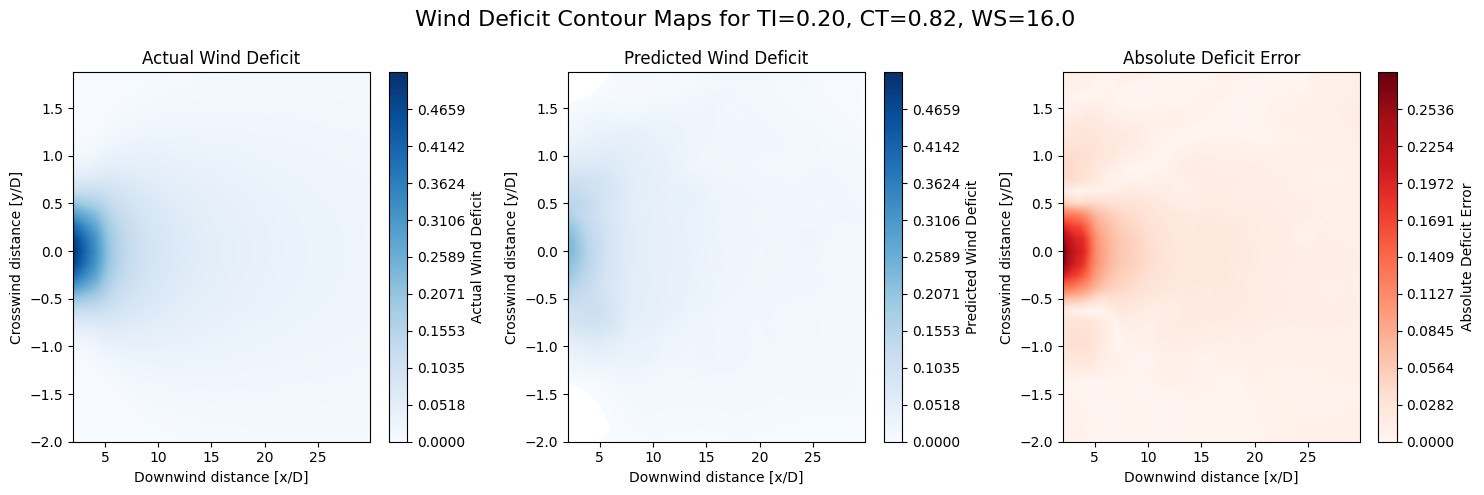

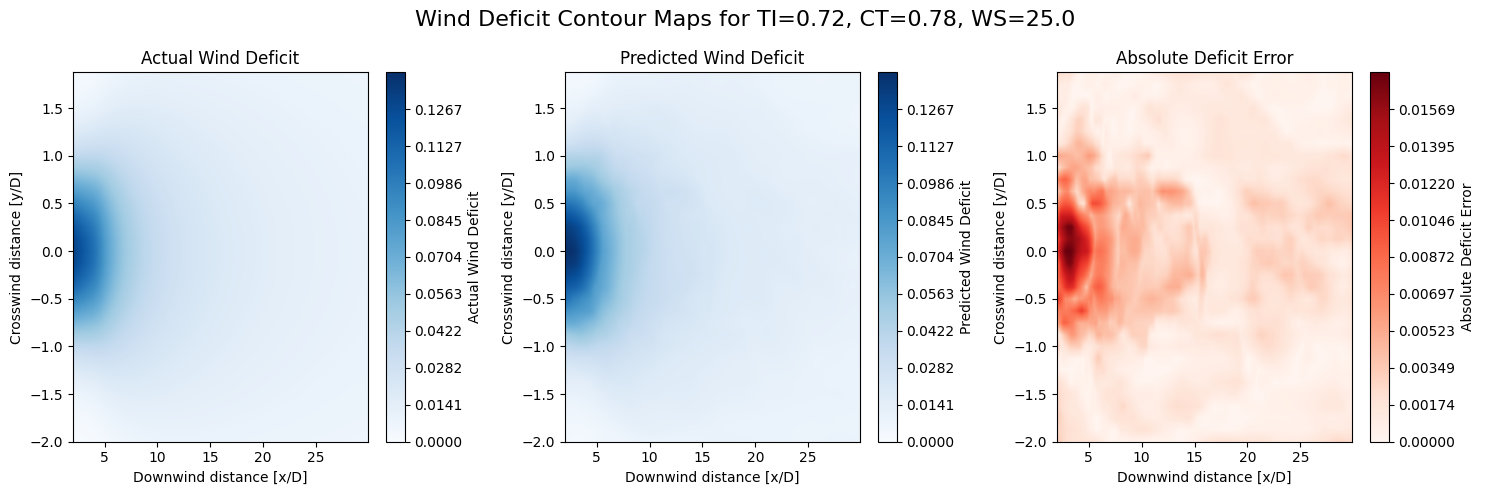

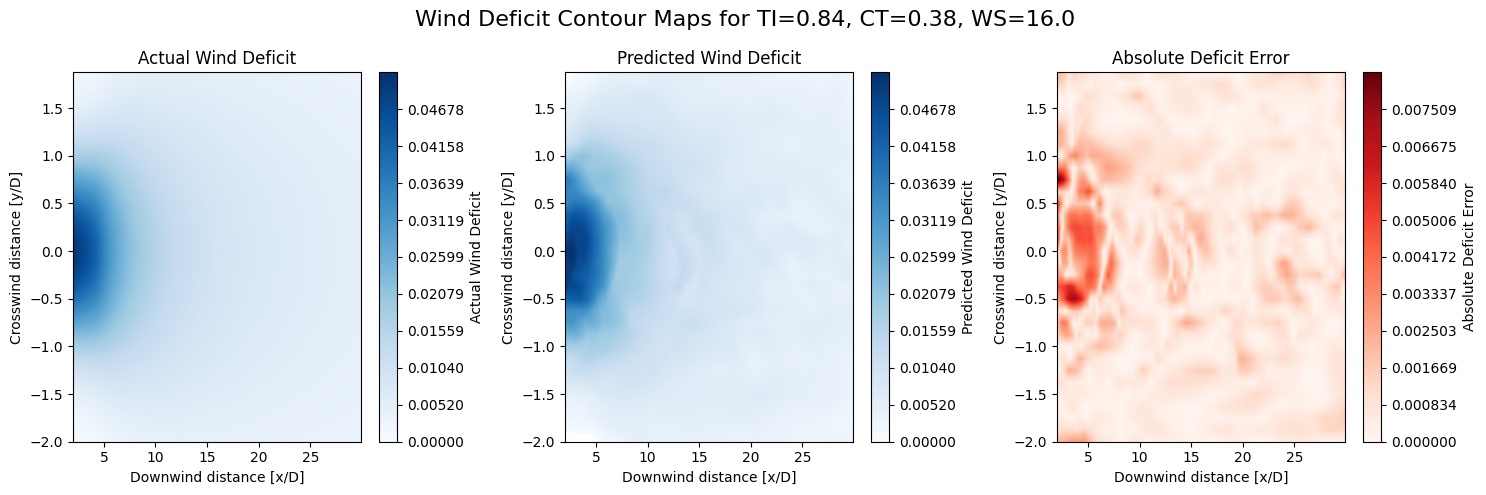

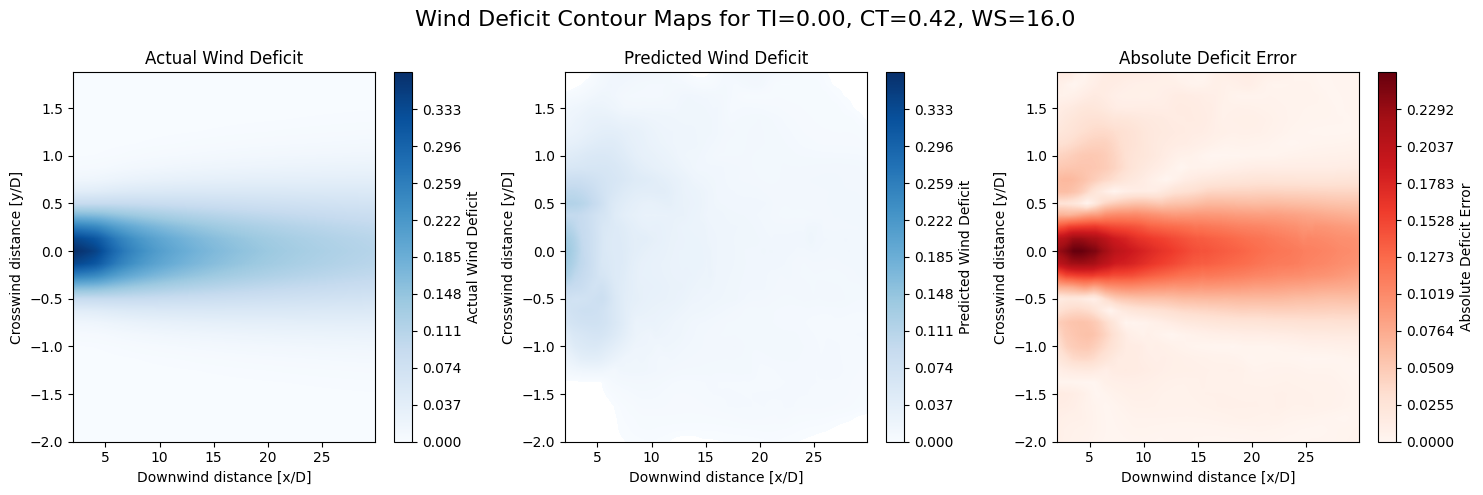

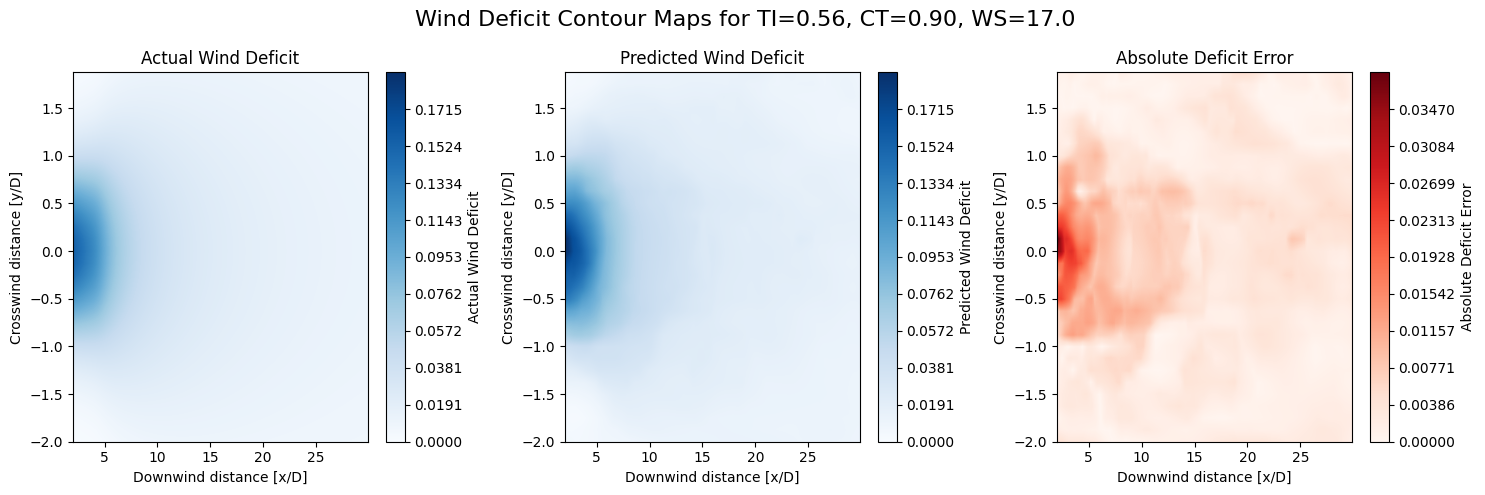

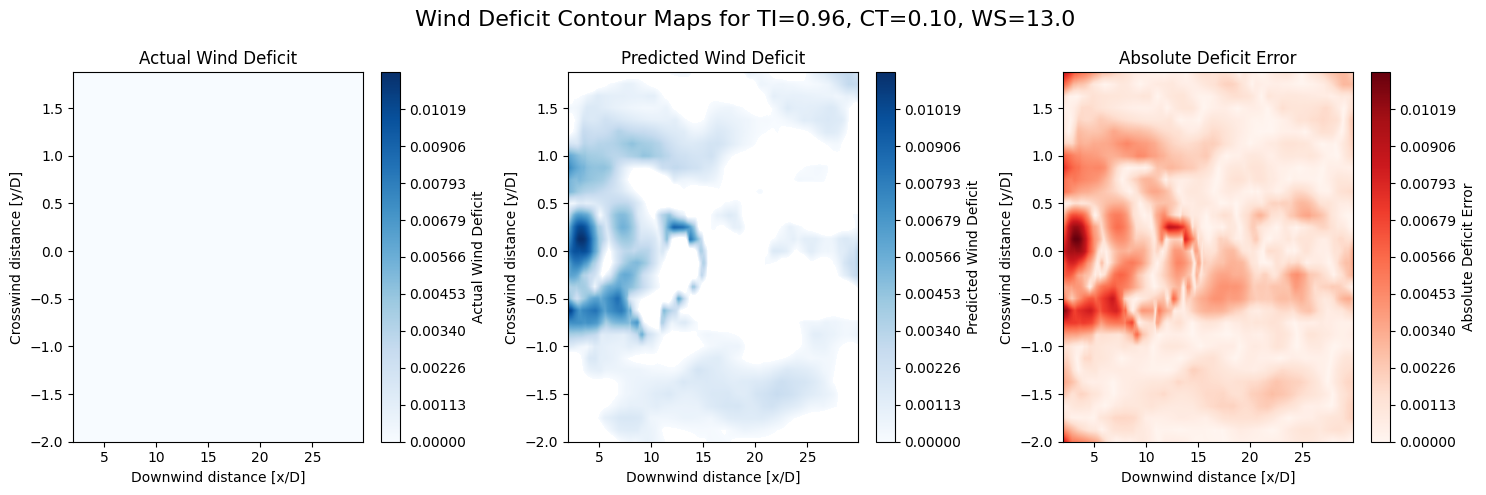

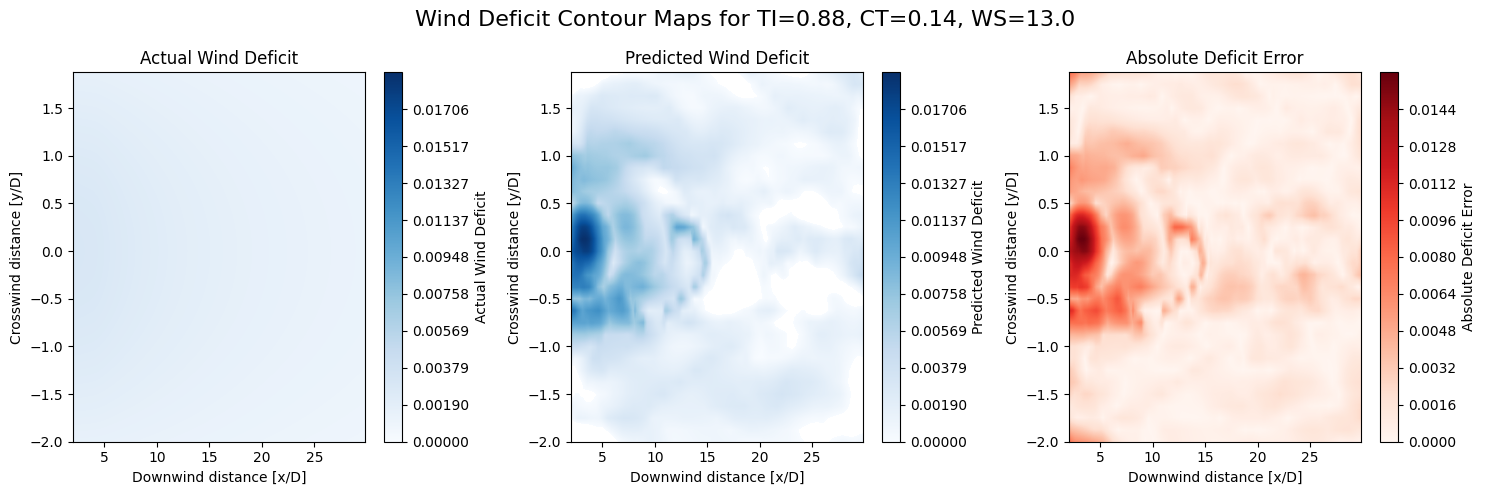

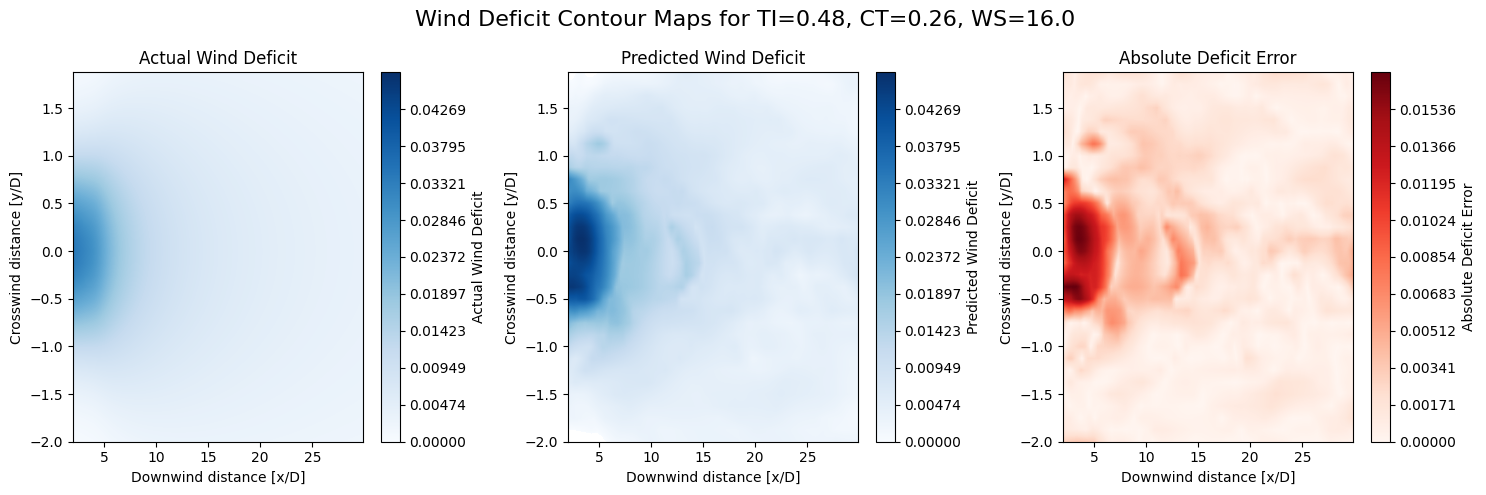

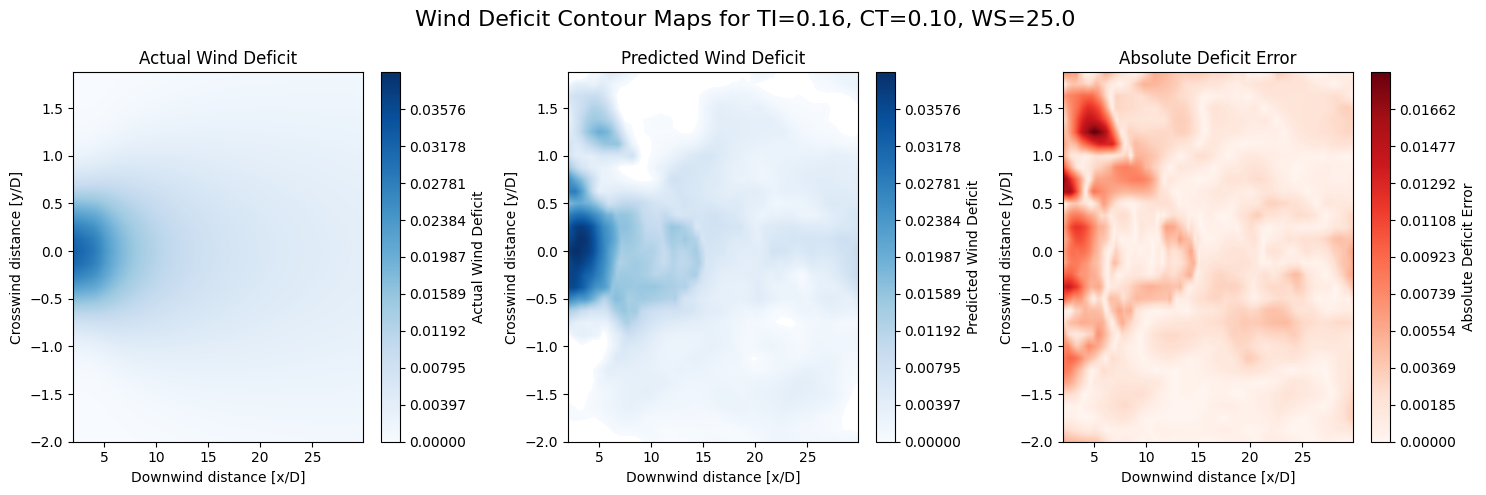

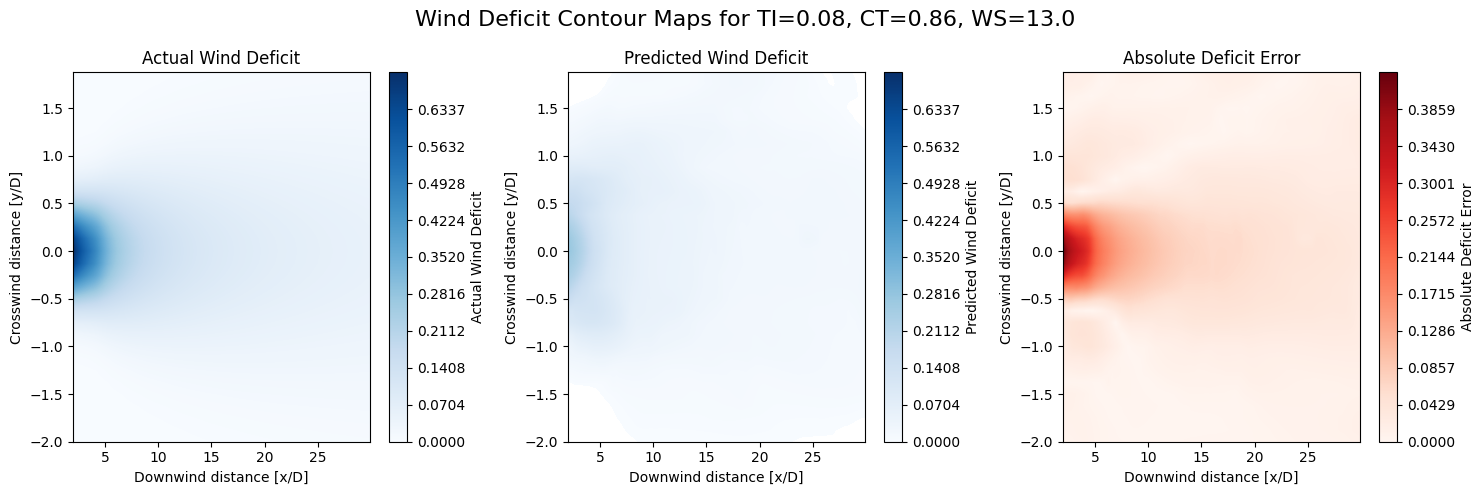

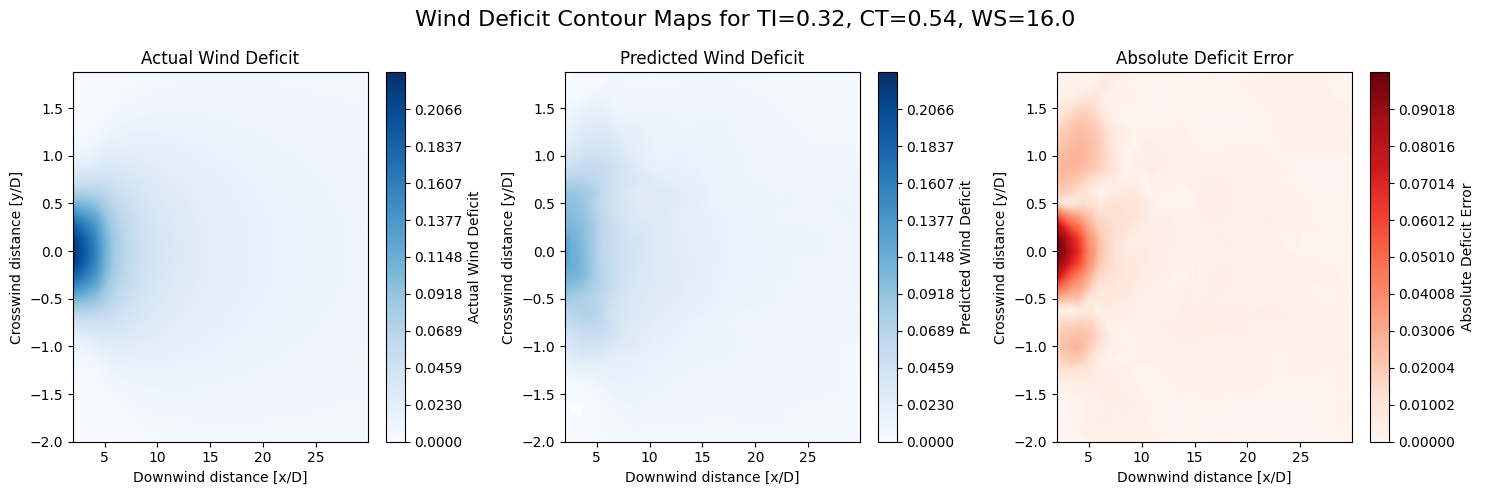

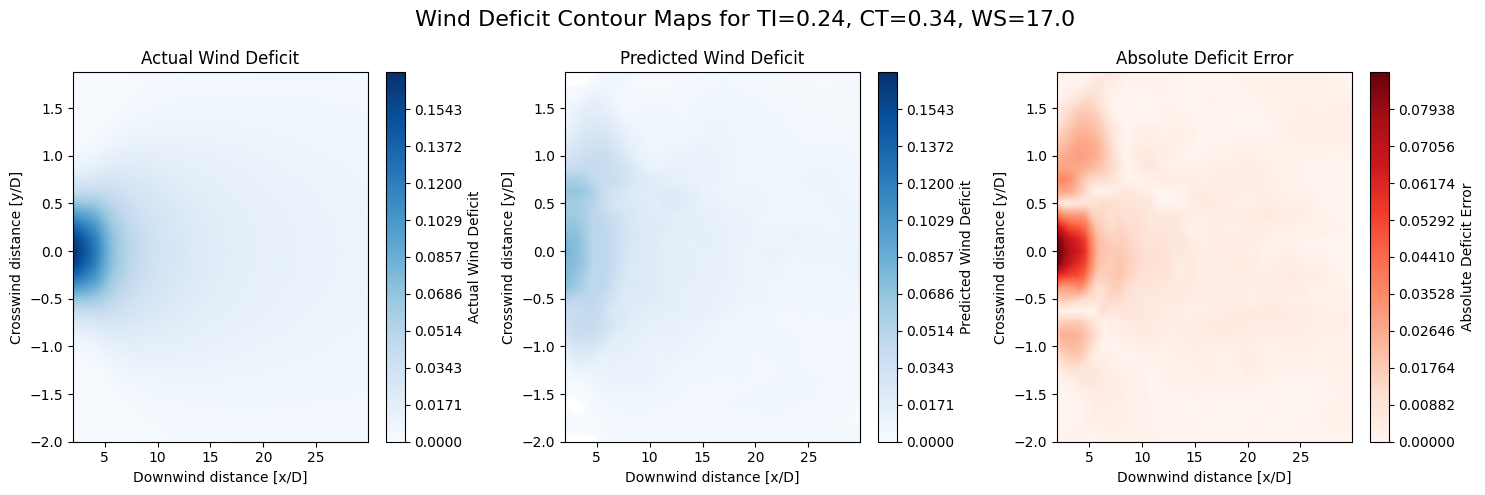

KeyboardInterrupt: 

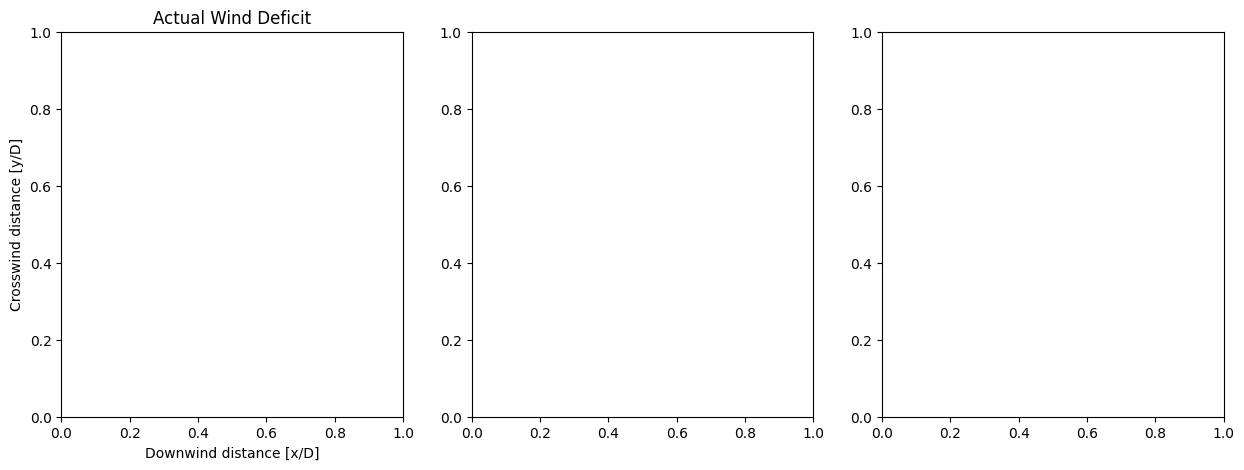

In [ ]:
test_dataset = test_dataloader.dataset
num_cells = test_dataset.num_cells
num_fields = len(test_dataset)//num_cells
field_indices = list(range(num_fields))
random.shuffle(field_indices)

with torch.no_grad():
    for field_idx in field_indices:
        ti, ct, ws, wake_field, predicted_wake_field = test_dataset.get_parameters_for_plotting_univariate(model, field_idx)
        plotting.plot_maps(test_dataset.X_grid, test_dataset.Y_grid, wake_field, predicted_wake_field, ti, ct, ws, error_to_plot='absolute')